## GOAL

Analyze financial transaction data to predit if a particular transaction data is fraudulent.

In [3]:
import boto3

import numpy as np 
import pandas as pd
import os
from sklearn.utils import shuffle

region = boto3.Session().region_name    

bucket = 'anomaly-detection-team-vypin'                     
prefix = 'sagemaker/talasila'

---
## DOWNLOAD

In [4]:
s3 = boto3.resource('s3')
data_bucket = 'anomaly-detection-team-vypin'
data_key = 'PS_20174392719_1491204439457_log.csv'
s3.Bucket(data_bucket).download_file(data_key, 'input_data.csv')

Read data into a pandas dataframe

In [26]:
df = pd.read_csv('./input_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


---
## Analysis

bin transaction amounts into 50K range

In [27]:
# bin amounts into 50K range
bins = range(0, 1000000, 50000)
labels = range(0, 950000, 50000)
df['binned'] = pd.cut(df['amount'], bins=bins, labels=labels)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0


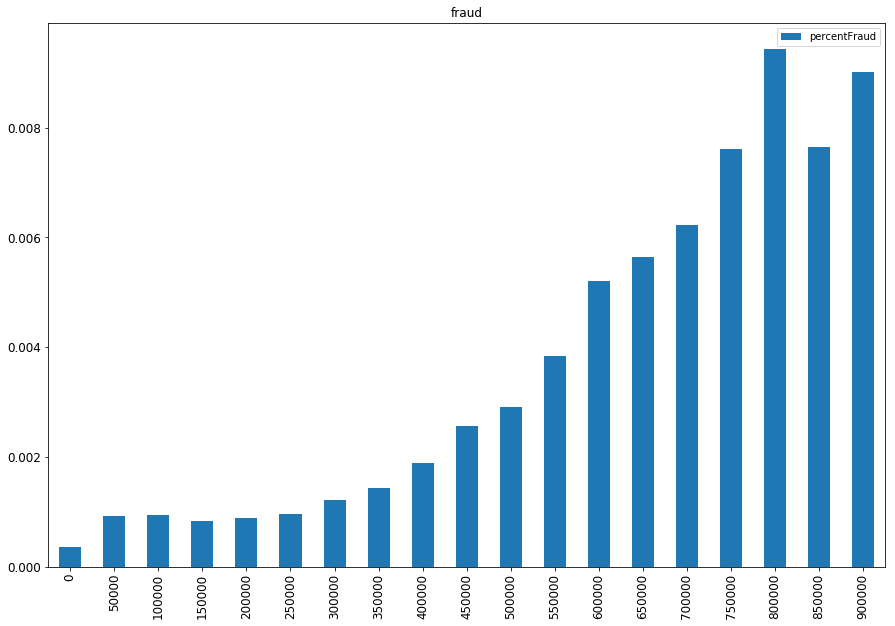

In [23]:
# analysis: set what percentage of tx in each bin is fraudulent

#df[['amount']].plot(kind='hist',bins=bins,rwidth=0.8)
adf1 = df['binned'].value_counts().to_frame('totalTx')
adf1['bin'] = adf1.index

fraud = df.loc[df['isFraud'] == 0].groupby(['binned']).size().to_frame('nonfraud')
adf1 = adf1.join(fraud, lsuffix='', rsuffix='', sort=False)
adf1['percentFraud'] = (adf1['totalTx'] - adf1['nonfraud'])/adf1['totalTx']

adf1[['bin','percentFraud']].plot(kind='bar', title ="fraud", figsize=(15, 10), legend=True, fontsize=12)



---
## MUNGING

In [28]:
df = df.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)
df = pd.get_dummies(df)

In [29]:
model_data = shuffle(df)
model_data

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
4250454,306,4961.55,99267.00,104228.55,467707.22,462745.67,1,0,0,0,0
3277862,251,124953.28,2420533.83,2545487.11,1348466.35,1223513.07,1,0,0,0,0
4923150,350,95545.96,125136.00,29590.04,70575.91,166121.88,0,1,0,0,0
5255425,371,19087.90,0.00,0.00,0.00,0.00,0,0,0,1,0
2611379,208,1662.36,169784.72,168122.36,0.00,0.00,0,0,0,1,0
2765789,213,77694.90,0.00,0.00,1371224.74,1448919.63,0,1,0,0,0
918123,43,146297.90,0.00,0.00,533423.02,679720.92,0,1,0,0,0
2729680,212,7678.80,61702.00,54023.20,0.00,0.00,0,0,0,1,0
6015914,451,18711.71,0.00,0.00,80157.70,98869.41,0,1,0,0,0
1020825,47,235529.65,759844.32,995373.97,3098530.37,2863000.72,1,0,0,0,0


Split data into the training, test and validation sets

In [32]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9*len(model_data))])  

train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

Copy to S3

In [33]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Training

In [35]:
import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import RandomCutForest
import pandas as pd

smclient = boto3.Session().client('sagemaker')
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket = 'anomaly-detection-team-vypin'                     
prefix = 'sagemaker/talasila'

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/train/train.csv'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

train_data = pd.read_csv('s3://{}/{}/train/train.csv'.format(bucket, prefix))

# run the training job on input data stored in S3
rcf.fit(rcf.record_set(train_data.as_matrix()))


INFO:sagemaker:Creating training-job with name: randomcutforest-2019-03-07-15-15-51-332


2019-03-07 15:15:51 Starting - Starting the training job...
2019-03-07 15:15:53 Starting - Launching requested ML instances......
2019-03-07 15:16:58 Starting - Preparing the instances for training........................
2019-03-07 15:20:59 Starting - Launched instance was unhealthy, replacing it!...
2019-03-07 15:21:53 Starting - Preparing the instances for training......
2019-03-07 15:22:53 Downloading - Downloading input data......
2019-03-07 15:23:43 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[03/07/2019 15:23:46 INFO 140717557802816] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recal

[03/07/2019 15:23:54 INFO 140717557802816] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 7515.303134918213, "sum": 7515.303134918213, "min": 7515.303134918213}}, "EndTime": 1551972234.896184, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1551972227.369661}

[03/07/2019 15:23:54 INFO 140717557802816] Early stop condition met. Stopping training.
[03/07/2019 15:23:54 INFO 140717557802816] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 4454, "sum": 4454.0, "min": 4454}, "Number of Batches Since Last Reset": {"count": 1, "max": 4454, "sum": 4454.0, "min": 4454}, "Number of Records Since Last Reset": {"count": 1, "max": 4453833, "sum": 4453833.0, "min": 4453833}, "Total Batches Seen": {"count": 1, "max": 4454, "sum": 4454.0, "min": 4454}, "Total Records

In [36]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-03-07-15-15-51-332


---
## Inference

Run inference for a small sample to test.

In [37]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-15-25-14-949
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-03-07-15-15-51-332


---------------------------------------------------------------------------------------!

In [38]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [39]:
train_data_numpy = train_data.as_matrix()
print(train_data_numpy[:6])
results = rcf_inference.predict(train_data_numpy[:6])
print(results)

[[3.80000000e+02 3.66690000e+02 3.29410000e+04 3.25743100e+04
  0.00000000e+00 3.66690000e+02 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.94000000e+02 1.87424020e+05 0.00000000e+00 0.00000000e+00
  3.72072092e+06 3.90814494e+06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.26000000e+02 1.14924770e+05 2.97780000e+04 0.00000000e+00
  2.51820771e+06 2.63313248e+06 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.62000000e+02 2.93783200e+05 0.00000000e+00 0.00000000e+00
  3.73648970e+05 6.67432160e+05 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.78000000e+02 4.80691000e+03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [3.97000000e+02 2.87551220e+05 4.11000000e+02 2.87962220e+05
  1.34783810e+05 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00

---
## Compute anomaly scores

Use batch transform to compute anomaly scores across the data set

In [ ]:
import boto3
import sagemaker
import json

validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket, prefix)
output_location = 's3://{}/{}/output/batch_transform'.format(bucket, prefix)

### Convert the validation set NumPy array to a CSV file and upload it to Amazon S3
#numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
#s3_client = boto3.client('s3')
#s3_client.upload_file('valid-data.csv', bucket, input_key)

# Initialize the transformer object
transformer = rcf.transformer(
    instance_type='ml.c4.xlarge',
    instance_count=1,
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=output_location
    )
# Start a transform job
transformer.transform(validation_data, content_type='text/csv', split_type='Line')
# Then wait until the transform job has completed
transformer.wait()

# Fetch validation result 
s3_client.download_file(output_location, 'validation.csv.out', 'valid-result')
with open('valid-result') as f:
    results = f.readlines()   
print("Sample transform result: {}".format(results[0]))

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-15-15-51-332
INFO:sagemaker:Creating transform job with name: randomcutforest-2019-03-07-15-41-00-516


....................................................